As we learned the `caret` library, we actually used two features to predict `tidy_price`. We didn't go into the specifics of using two features, but in this file we'll explore how adding new features to the algorithm changes how it classifies new listings.

Deciding a proper rental price for a listing is a complex task, requiring much more information than how many people a listing can accommodate. It could be helpful to incorporate more information into creating a prediction since rental listings have many qualities to them, qualities that could be shared. By adding more features, we hope to keep distances between similar listings small while increasing distances of listings that are not similar to ours. These two changes together help increase prediction quality.

Adding an additional feature to the k-nearest neighbors algorithm corresponds to adding another dimension to space. When we used just the `accommodates` column, space was represented by a one-dimensional line. After we `add maximum_nights` to the algorithm, space becomes a two dimensional plane

Adding yet another feature, a third, the "space" will become three dimensional, and so on. Using `k` features in the algorithm means that the "space" will be in `k`-dimensions. Past three dimensions, we aren't able to really visualize what this space looks like, but the intuition of the algorithm remains the same. The Euclidean distance formula can accommodate `k` features:

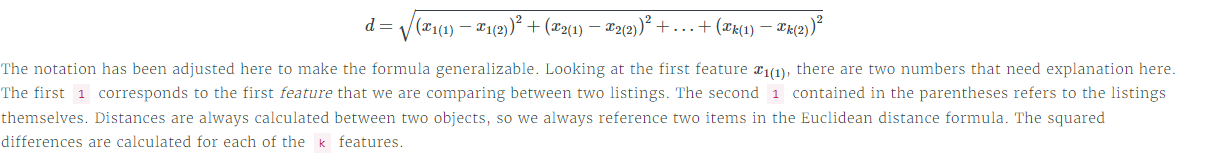

In practice, we won't have to deal with the distance formula at all since `caret` handles all of the calculations. The main point of this is to give insight on how the k-nearest neighbors algorithm incorporates more features into its machine learning goal.

When we judge similarity between neighbors, we use Euclidean distance to give a numerical measure to similarity. Using Euclidean distance turns judging similarity between neighbors into a matter of comparing distances. However, using Euclidean distance also places a limitations on the types of data we can use in the k-nearest neighbors algorithm. Euclidean distance requires numerical features, which means that other types of features are barred form use. This includes factors, characters, and missing values.

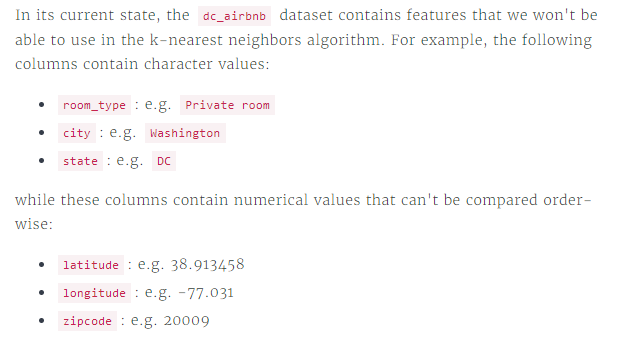

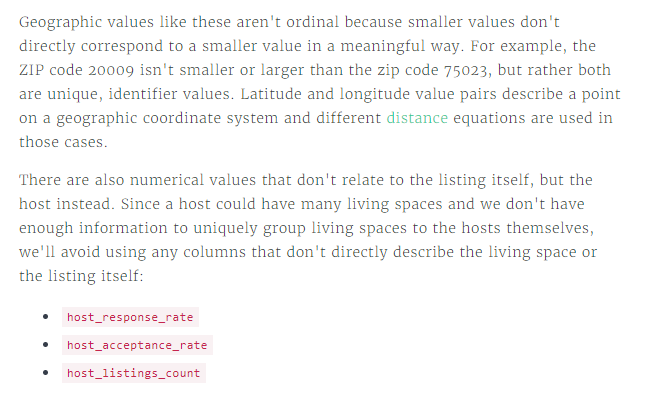

Let's remove these nine columns from the data.

**Task**

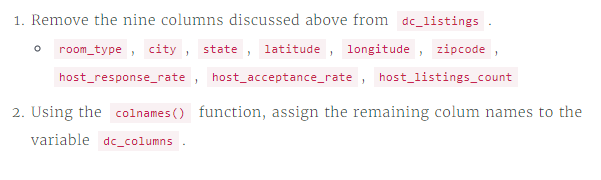

**Answer**

`dc_listings <- dc_listings %>%
    select(-room_type, -city, -state, 
           -latitude, -longitude, -zipcode, 
           -host_response_rate, -host_acceptance_rate, -host_listings_count)`
           
`dc_columns <- colnames(dc_listings)`

Now that we've dealt with the removed non-essential columns, we'll handle the missing data that is still present in the dataset. Handling missing values is difficult because we can never be sure why the data went missing. Data can be missing for a variety of issues, ranging from simple data entry error to the nature of the data itself.

Most machine learning algorithms aren't able to work with missing values present in the data, so we have to make a choice on how we deal with them. The most common ways that people deal with missing data is to: 1) remove any columns or rows that have missing data or 2) use **imputation** to create an "educated guess" at what the missing values should be.

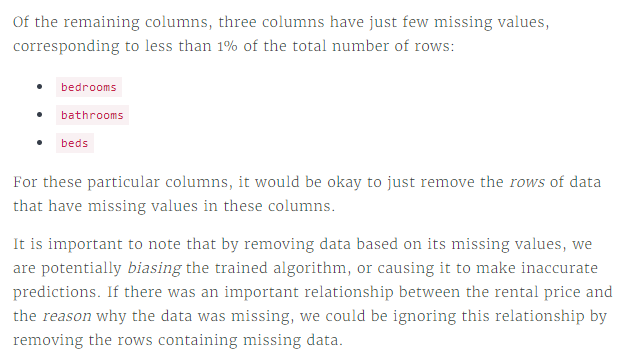

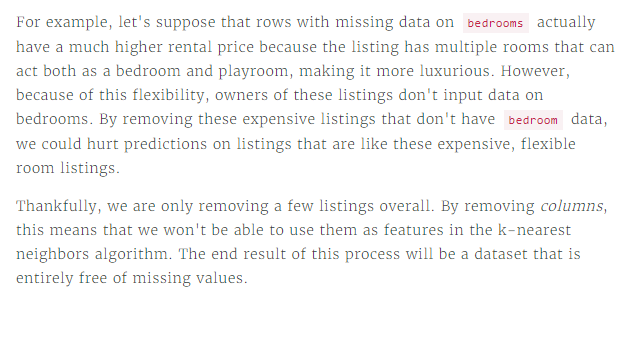

**Task**

Remove all rows that contain a missing value for the `bedrooms`, `bathrooms`, or `beds` column from `dc_listings`.

**Answer**

`dc_listings <- dc_listings %>%
  filter(
    !is.na(bedrooms),
    !is.na(bathrooms),
    !is.na(beds)
    )`

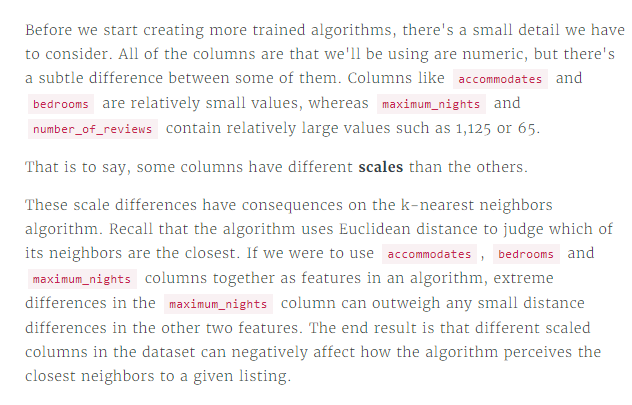

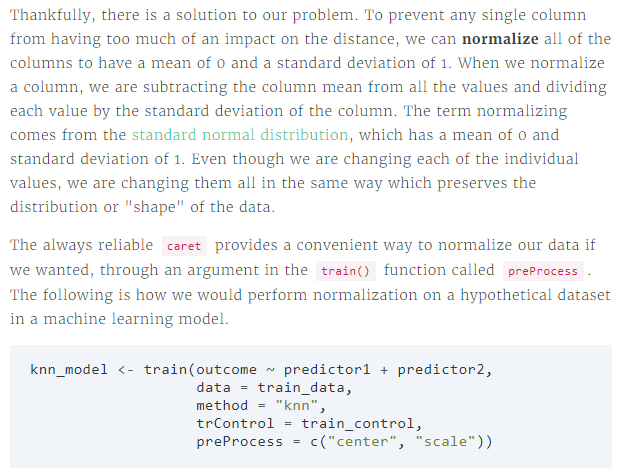

The hypothetical code above is similar to what we saw in the last file. The only change that we've made here is that we've specified what we wanted in the `preProcess` argument. The words `"center"` and `"scale"` refer to subtracting the mean and dividing by the standard deviation, respectively.

**Task**

Using the `train_listings` data, create a new k-nearest neighbors model and make sure to normalize the columns. 
    * Predict `tidy_price` from `bedrooms` and `maximum_nights`.
    
**Answer**

`set.seed(1)
library(readr)
library(dplyr)
library(stringr)`

`dc_listings <- read.csv('tidy_dc_airbnb.csv') %>%
  select(-room_type, -city, -state, 
         -latitude, -longitude, -zipcode, 
         -host_response_rate, -host_acceptance_rate, -host_listings_count,
         -cleaning_fee, -security_deposit) %>%
  filter(
    !is.na(bedrooms),
    !is.na(bathrooms),
    !is.na(beds)
  )`
  
`library(caret)
train_indices <- createDataPartition(y = dc_listings[["tidy_price"]],
                                     p = 0.7,
                                     list = FALSE)
train_listings <- dc_listings[train_indices,]
test_listings <- dc_listings[-train_indices,]
train_control <- trainControl(method = "none")`

`knn_model <- train(tidy_price ~ bedrooms + maximum_nights,
                   data = train_listings,
                   method = "knn",
                   trControl = train_control,
                   preProcess = c("center", "scale"))`

`condition1 <- function() {
    if (length(knn_model[["coefnames"]]) == 2) {
        return(c(TRUE))
    } else {
        return(c(FALSE, "The model doesn't appear to have the correct number of features."))
    }
}`

`print(condition1())`

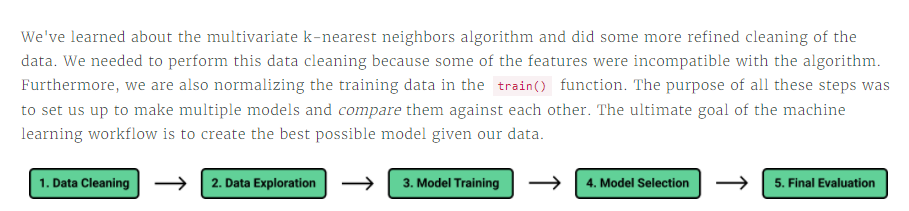

Thanks to `caret`, we have everything we need to easily create these models. We'll need to create two models from the training data. These two models will use different features in the data, and we'll walk through how to compare them.

**Task**

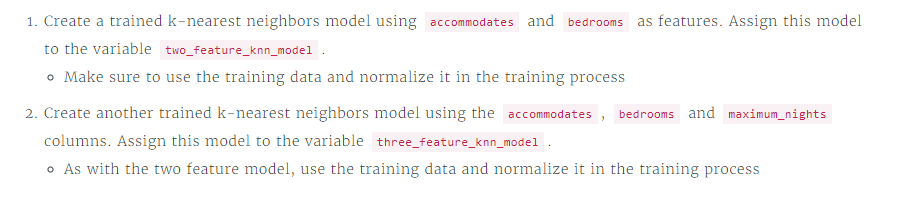


**Answer**

`set.seed(1)
library(caret)
train_indices <- createDataPartition(y = dc_listings[["tidy_price"]],
                                     p = 0.7,
                                     list = FALSE)`
                                     
`train_listings <- dc_listings[train_indices,]
test_listings <- dc_listings[-train_indices,]
train_control <- trainControl(method = "none")`

`two_feature_knn_model <- train(tidy_price ~ accommodates + bedrooms,
                               data = train_listings,
                               method = "knn",
                               trControl = train_control,
                               preProcess = c("center", "scale"))`
                               
`three_feature_knn_model <- train(tidy_price ~ accommodates + bedrooms + maximum_nights,
                               data = train_listings,
                               method = "knn",
                               trControl = train_control,
                               preProcess = c("center", "scale"))`

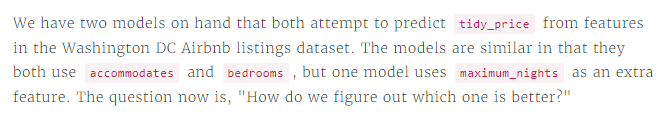

We learned about RMSE and its role as an error metric. Recall that we use error metrics to evaluate the performance of a machine learning model. We calculated an RMSE for a single model, but didn't really do anything with it. That's because there really wasn't anything we could do with it. 

Just having the RMSE for a single model only really tells how much error the model has on average. Error metrics really shine when we are able to compare models against each other. Intuitively, we want model error to be as small as possible, which corresponds to having a smaller RMSE. So with multiple models, we can choose the best model based on which one has the smallest relative RMSE. Being able to compare RMSEs allows us to decide if adding additional features reduces the RMSE in a meaningful way.

With this in mind, we are going to take the two models that we created and make a nice tibble for us to compare the two models. We'll be leveraging some useful functions in the `tidyverse` to do so. We could technically just calculate the RMSE for each model and compare it manually, but good presentation is also an important skill for any data scientist or analyst. 

**Task**

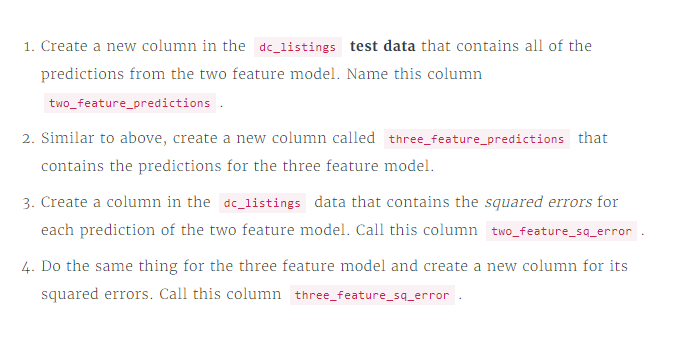

**Answer**

`test_listings <- test_listings %>%
  mutate(
    two_feature_predictions = predict(two_feature_knn_model, newdata = test_listings),
    three_feature_predictions = predict(three_feature_knn_model, newdata = test_listings),
    two_feature_sq_error = (tidy_price - two_feature_predictions)^2,
    three_feature_sq_error = (tidy_price - three_feature_predictions)^2
  )`

Above, we created the squared error columns needed to calculate the RMSE error metric. Before we can summarize everything into a neat table, we need to deal with a small issue in the data format. Both `two_feature_sq_error` and `three_feature_sq_error` contain the same type of information: squared error. 

In order to make a nice table programmatically, we prefer that all of this information be in the same column. Furthermore, we want to be able to distinguish which squared errors came from which model — either the two or three feature model. In short, we want to convert the test data into **long format**. "Long" refers to the fact that we are taking multiple columns and essentially "stacking" them on top of each other. 

In the interest of learning, the opposite of long format is **wide format**, where we can have different columns representing the same type of information. In general, long format data is more convenient for plotting, while wide format data is better for human viewing.

Our test data is currently in wide format. We'll learn about a function that performs the conversion from wide to long format. This function is called `pivot_longer()`, and it comes from the `tidyr` library. There are four arguments that we should provide to the `pivot_longer()` function, which we'll go through in an example below. Let's say that we want to take both of the prediction columns and convert into long format.

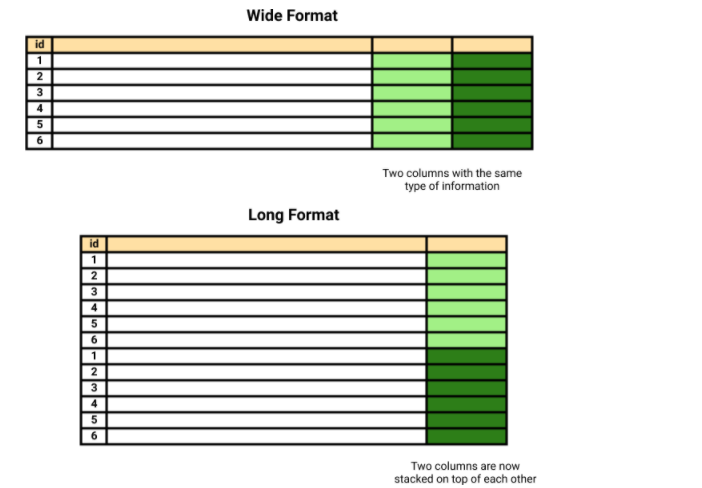

`library(tidyr)`

`test_listings <- test_listings %>%
    pivot_longer(
        cols = two_feature_predictions:three_feature_predictions,
        names_to = "model",
        values_to = "predictions"
    )`
    
The first argument is `cols`, where we need to specify which columns we want to "stack" on top of each other. In this case, `two_feature_predictions` and `three_feature_predictions` are next to each other in test_listings, so we can use the colon : as shorthand. Alternatively, we can provide a vector containing the column names that we want to stack. 

The `names_to` argument represents a new column in the `test_listings` data that will help us distinguish between the predictions once they're stacked. After `pivot_longer()` is executed, a model column is created, and its values will be the columns that were originally stacked. That is to say, each prediction value is associated with either `two_feature_predictions` or `three_feature_predictions`. The final argument `values_to will` be the column name that the stacked predictions values will take.

**Task**

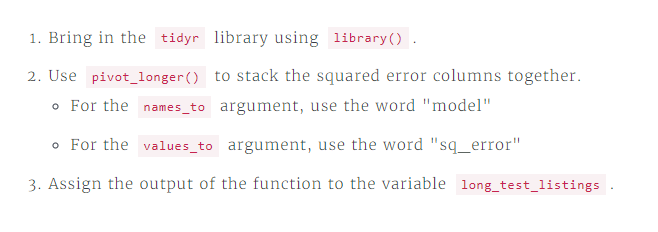

**Answer**

`library(tidyr)`

`long_test_listings <- test_listings %>%
  pivot_longer(
    cols = two_feature_sq_error:three_feature_sq_error,
    names_to = "model",
    values_to = "sq_error"
  )`

Now that the data is in long format, we can transform it into a nicely organized table for viewing. To do this, we can use a combination of two other functions from the `dplyr` library: `group_by()` and `summarize()`. 

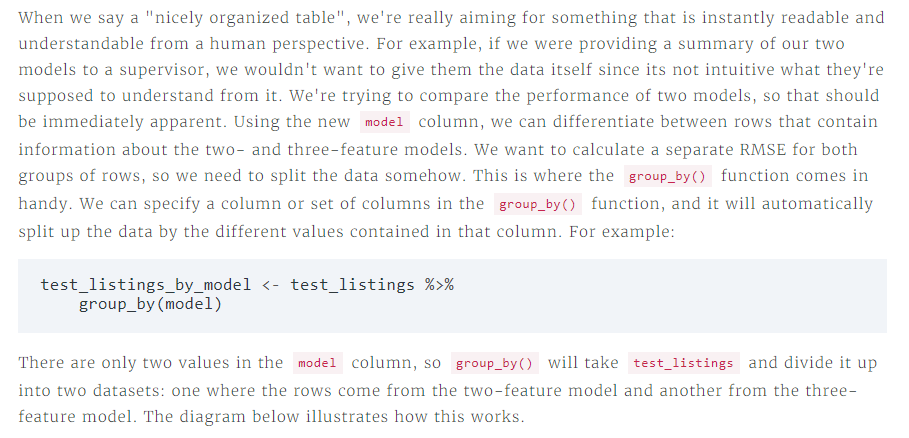

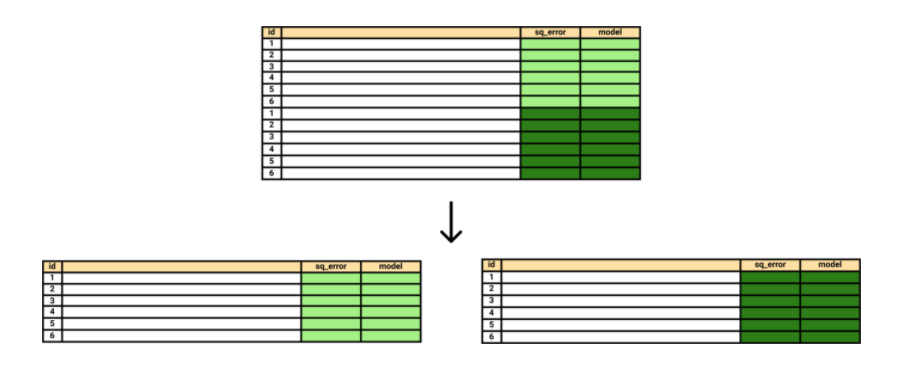

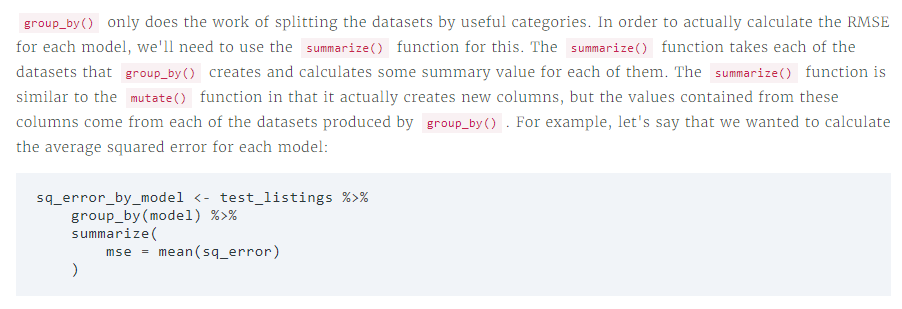

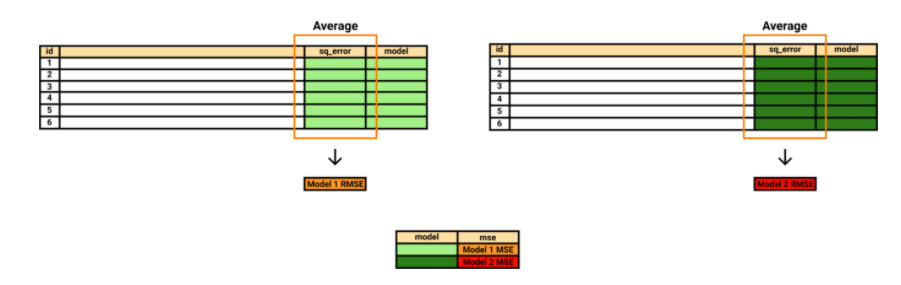

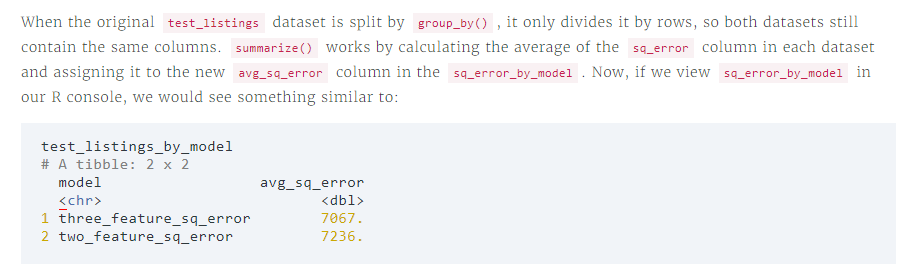

The end result is a compact table that lets us immediately compare the two models. The table above already hints to which model performs better, but we should calculate the RMSE just to make sure. As a small note, `summarize()` uses the American spelling of the word, but R also recognizes `summarise()`.

**Task**

1. Using `group_by` and `summarize()`, calculate the RMSE for each model. Assign this new table to the variable `rmse_by_model`.
2. After taking a look at `rmse_by_model`, make a judgment as to which model performs better. If the two feature model is better, assign the word `"two_feature"` to the variable `better_model`. If not, assign `"three_feature"` model to `better_model`.

**Answer**

`set.seed(1)`

`test_listings <- test_listings %>%
  pivot_longer(
    cols = two_feature_sq_error:three_feature_sq_error,
    names_to = "model",
    values_to = "sq_error"
  )`
  
`rmse_by_model <- test_listings %>%
  group_by(model) %>%
  summarize(
      rmse = sqrt(mean(sq_error))
  )`
  
`better_model <- "three_feature"`

The three feature model just barely edges out the two feature model, so we might conclude that adding `maximum_nights` as a feature for prediction is not very useful.

As we wrap up this, we feel it's important to take a step back to really showcase the power and utility of the `tidyverse` libraries. As we've worked through we've created updated versions of the `test_listings` data set and reassigned it back to the `test_listings` variable. 

While there's nothing wrong with this in practice, we can use the `%>%` operator to essentially streamline the whole process. Doing so creates a large chunk of code, but it effectively puts all of the data cleaning and processing steps into one place. With some proper formatting, we can easily distinguish actions each part of the pipeline is performing and change code wherever we may need. Below is an example of the workflow:

`tidy_test_listings <- test_listings %>%
  pivot_longer(
    .,
    cols = two_feature_sq_error:three_feature_sq_error,
    names_to = "model",
    values_to = "sq_error"
  ) %>%
  group_by(model) %>%
  summarize(
    rmse = (
    rmse = sqrt(mean(sq_error))
  )`

The above code places the pivot, grouping and summarizing steps into one pipeline. The `%>%` function allows us to take the output of one function and place it directly as input to another function. 